### Librabries Imported

In [225]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Extraction

####### Query Used
select io.id as invoice_id,od.billing_unit_count as unit_count,io.created_date as invoice_date,od.rate as unit_price,eu.id as customer_id,eu.client_type as customer_type,p.name as partner
from orders od
join invoice io on io.id=od.invoice_id and io.active=true
join enquiry e on od.enquiry_id = e.id and e.active=true
join eos_user eu on e.eos_user_id = eu.id and eu.active=true
join partner p on eu.partner_id = p.id and p.active=true
join file f on f.enquiry_id=e.id and f.active=true
where od.active=true
and (io.created_date >= '2019-08-01 00:00:00' and io.created_date <= '2019-12-31 23:59:59')
group by io.id,io.created_date,od.rate,eu.id,p.name,od.created_date,od.billing_unit_count
order by od.created_date desc;

In [226]:
DataFrame= pd.read_csv("C:\\Program Files\\Python36\\suven\\Notebooks\\customer_segmentation.csv",encoding='unicode_escape')
DataFrame.head()

,invoice_id,unit_count,invoice_date,unit_price,customer_id,customer_type,partner,total_price
0,1040364,362,2019-12-31 15:42:38,70.000,10964,individual,KOR,25340.00
1,1040544,200,2019-12-31 22:53:59,6.000,259217,individual,JPN,1200.00
2,1040289,749,2019-12-31 14:02:56,120.000,183017,individual,KOR,89880.00
3,1040925,214,2019-12-31 00:00:00,0.245,287569,corporate,CHN,52.43
4,1040908,3385,2019-12-31 00:00:00,0.235,276383,corporate,CHN,795.47


In [227]:
DataFrame.shape

(89125, 8)

#### Customer Distribution partner wise 

In [228]:
#DataFrame=DataFrame[DataFrame['customer_type']=='individual']
cust_data_partner=DataFrame[['customer_id','partner']].drop_duplicates()
cust_data_partner.groupby(['partner'])['customer_id'].aggregate('count').reset_index().sort_values('customer_id',ascending=False)

,partner,customer_id
7,JPN,18372
9,KOR,7377
1,CHN,6761
2,ENG,2860
0,BRL,1510
17,TWN,1140
16,TFG,974
19,WASG,749
20,WKH,573
14,SAGEG,286


#### Keeping Highest performing partner for both retail and corporate 

In [229]:
DataFrame=DataFrame.query("partner=='JPN'").reset_index(drop=True)

#### Check Missing Values in Dataset/DataFrame  

In [230]:
DataFrame.isnull().sum(axis=0)

invoice_id       0
unit_count       0
invoice_date     0
unit_price       0
customer_id      0
customer_type    0
partner          0
total_price      0
dtype: int64

#### Validate the negative value in unit price column 

In [231]:
DataFrame.unit_count.min()

1

#### Removing Data with unit_price as 0 because it can be a test inq   

In [232]:
DataFrame=DataFrame[(DataFrame['unit_count']>0)]

In [233]:
DataFrame.head()

,invoice_id,unit_count,invoice_date,unit_price,customer_id,customer_type,partner,total_price
0,1040544,200,2019-12-31 22:53:59,6.0,259217,individual,JPN,1200.0
1,1040437,139,2019-12-31 17:12:36,18.0,112272,individual,JPN,2502.0
2,1040081,364,2019-12-31 10:58:57,12.0,9551,individual,JPN,4368.0
3,1039912,1,2019-12-30 23:37:54,1.0,596720,corporate,JPN,1.0
4,1040222,998,2019-12-31 12:44:04,6.0,172039,individual,JPN,5988.0


### RFM Modelling Implementation

####R=Latest Date-Latest invoice date,F=count of invoice no. of transaction(s),M=sum of Total Amount of each client

In [234]:
import datetime as dt

In [235]:
DataFrame.invoice_date=DataFrame.invoice_date.str[0:10]
DataFrame['invoice_date'] = pd.to_datetime(DataFrame['invoice_date'])
DataFrame.head()
Latest_date= dt.datetime(2020,1,1)

In [236]:
 #RFM Code
RFMScores = DataFrame.groupby(['customer_id']).agg({'invoice_date':lambda x:(Latest_date-x.max()).days,'invoice_id':lambda x:len(x),'total_price':lambda x:x.sum()})
RFMScores['invoice_date']=RFMScores['invoice_date'].astype(int)
RFMScores.rename(columns={'invoice_date':'Regency',
                         'invoice_id':'Frequency',
                         'total_price':'Monetary'},inplace=True)
RFMScores.reset_index().head()

,customer_id,Regency,Frequency,Monetary
0,45,145,1,40887.0
1,50,36,1,1482.0
2,74,84,2,39588.0
3,86,11,1,3576.0
4,138,88,1,3960.0


#### Descriptive Statistics on Regency

In [237]:
RFMScores.Regency.describe()

count    18372.000000
mean        66.935500
std         44.053795
min          1.000000
25%         28.000000
50%         63.000000
75%        104.000000
max        153.000000
Name: Regency, dtype: float64

#### Regency Distribution Plot 

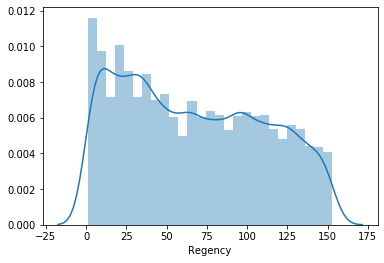

In [238]:
import seaborn as sns
x=RFMScores['Regency']
ax=sns.distplot(x)

#### Descriptive Statistics on Frequency

In [239]:
RFMScores.Frequency.describe()

count    18372.000000
mean         1.697910
std          2.514163
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        144.000000
Name: Frequency, dtype: float64

#### Plotting the graph for frequency less than 10 

#### Frequency Distribution  Plot

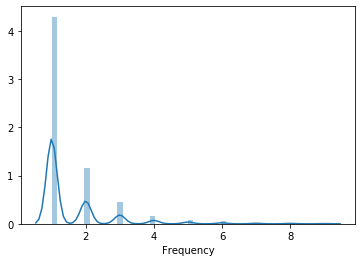

In [240]:
import seaborn as sns
x=RFMScores.query('Frequency < 10')['Frequency']
ax=sns.distplot(x)

#### Monetary Distribution Plot 

In [241]:
RFMScores.Monetary.describe()

count    1.837200e+04
mean     4.847973e+04
std      8.065162e+04
min      0.000000e+00
25%      7.244250e+03
50%      2.741350e+04
75%      5.969250e+04
max      3.314480e+06
Name: Monetary, dtype: float64

#### Plotting Monetary histograph for value less then 10000 

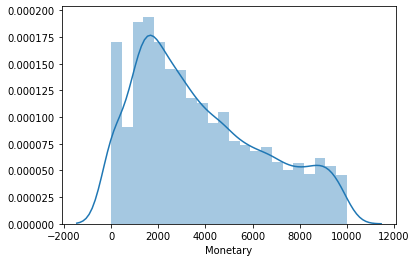

In [242]:
import seaborn as sns
x=RFMScores.query('Monetary < 10000')['Monetary']
ax=sns.distplot(x)

####  Split into four segments as quantiles

In [243]:
quantiles=RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles=quantiles.to_dict()
quantiles

{'Regency': {0.25: 28.0, 0.5: 63.0, 0.75: 104.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 7244.25, 0.5: 27413.5, 0.75: 59692.5}}

#### Functions to create R,F and M model 

In [244]:
def RScoring(x,p,d):
    if x <=d[p][0.25]:
        return 1
    elif x<=d[p][0.5]:
        return 2
    elif x<=d[p][0.75]:
        return 3
    else:
        return 4
    
def FandMScoring(x,p,d):
    if x <=d[p][0.25]:
        return 4
    elif x<=d[p][0.5]:
        return 2
    elif x<=d[p][0.75]:
        return 3
    else:
        return 1

####  Adding R,F and M segment values to function

In [245]:
RFMScores['R']=RFMScores['Regency'].apply(RScoring,args=('Regency',quantiles,))
RFMScores['F']=RFMScores['Frequency'].apply(FandMScoring,args=('Frequency',quantiles,))
RFMScores['M']=RFMScores['Monetary'].apply(FandMScoring,args=('Monetary',quantiles,))
RFMScores.head()

,Regency,Frequency,Monetary,R,F,M
customer_id,,,,,,
45,145,1,40887.0,4,4,3
50,36,1,1482.0,2,4,4
74,84,2,39588.0,3,3,3
86,11,1,3576.0,1,4,4
138,88,1,3960.0,3,4,4


#### Calculating RFM Scores and Adding them,Concatenating RFM Scores together as RFMScore group 

In [246]:
RFMScores['RFMGroup']=RFMScores.R.map(str)+RFMScores.F.map(str)+RFMScores.M.map(str)
RFMScores.reset_index().head()

,customer_id,Regency,Frequency,Monetary,R,F,M,RFMGroup
0,45,145,1,40887.0,4,4,3,443
1,50,36,1,1482.0,2,4,4,244
2,74,84,2,39588.0,3,3,3,333
3,86,11,1,3576.0,1,4,4,144
4,138,88,1,3960.0,3,4,4,344


#### Adding RFMGroup Score 

In [247]:
RFMScores['RFMScore']=RFMScores[['R','F','M']].sum(axis=1)
RFMScores.reset_index().head()

,customer_id,Regency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,45,145,1,40887.0,4,4,3,443,11
1,50,36,1,1482.0,2,4,4,244,10
2,74,84,2,39588.0,3,3,3,333,9
3,86,11,1,3576.0,1,4,4,144,9
4,138,88,1,3960.0,3,4,4,344,11


#### Assigning loyalty level to  customer

In [248]:
Loyalty_level=['premium_plus','premium','normal','focused']
Score_cut=pd.qcut(RFMScores.RFMScore,q=4,labels=Loyalty_level)
RFMScores['RFM_Loyalty_segment']=Score_cut.values
RFMScores.reset_index().head()

,customer_id,Regency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_segment
0,45,145,1,40887.0,4,4,3,443,11,focused
1,50,36,1,1482.0,2,4,4,244,10,normal
2,74,84,2,39588.0,3,3,3,333,9,premium
3,86,11,1,3576.0,1,4,4,144,9,premium
4,138,88,1,3960.0,3,4,4,344,11,focused


#### Validate the data for RFMgroup = 111 

In [249]:
RFMScores['partner']=DataFrame['partner']
RFMScores[(RFMScores['RFMGroup']=='111')&(RFMScores['partner']=='JPN')].sort_values('Monetary',ascending=False).reset_index().head(10)

,customer_id,Regency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_segment,partner
0,27248,1,63,917121.0,1,1,1,111,3,premium_plus,JPN
1,29526,21,12,649750.0,1,1,1,111,3,premium_plus,JPN
2,25724,1,18,577140.0,1,1,1,111,3,premium_plus,JPN
3,4367,5,19,559025.0,1,1,1,111,3,premium_plus,JPN
4,16362,27,16,548554.0,1,1,1,111,3,premium_plus,JPN
5,9555,1,6,546938.0,1,1,1,111,3,premium_plus,JPN
6,12085,23,6,479525.0,1,1,1,111,3,premium_plus,JPN
7,6227,28,8,476684.0,1,1,1,111,3,premium_plus,JPN
8,11135,6,5,471360.0,1,1,1,111,3,premium_plus,JPN
9,14101,5,3,378748.0,1,1,1,111,3,premium_plus,JPN
